# Линейная регрессия: переобучение и регуляризация

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LassoCV
import matplotlib.ticker as ticker
%matplotlib inline

# Анализ данных

In [2]:
df = pd.read_csv('bikes_rent.csv') #загрузка данных из .csv файла в датафрейм
df.head()  #вывод первых 5-ти строк

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов **(целевой признак)**

**Вывод: есть вещественные, бинарные и номинальные (порядковые) признаки, в дальнейшем будем работать с ними как с вещественными.**

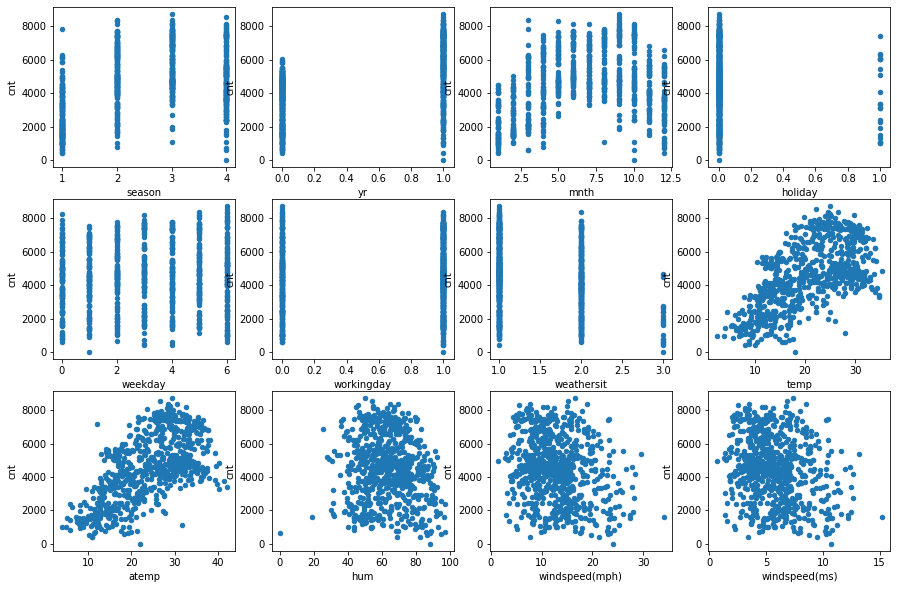

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4]) 
#визуализация как целевой признак зависит от остальных признаков

## Проверка на мультиколлинеарность

### Линейный коэффициент корреляции Пирсона 

![Формула](https://statanaliz.info/wp-content/uploads/2019/04/corr_form_3.png)

In [8]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr() #попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


In [9]:
df.corrwith(df.cnt)[:-1] #корреляция Пирсона между признаками и целевой переменной

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

**Вывод: В матрице имеются еще две пары сильно коррелирующих столбцов: `temp` и `atemp` (коррелируют по своей природе) и два `windspeed` (потому что это просто перевод одних единиц в другие).**

## Проверка масштаба признаков

In [11]:
df.mean() #средние признаков

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

**Вывод: Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки**

In [18]:
df_shuffled = shuffle(df, random_state=123) #перемешивам выборку (для кросс-валдации)
X = scale(df_shuffled[df_shuffled.columns[:-1]]) #нормирование z-score
y = df_shuffled["cnt"]

## Обучение линейной модели на всех признаках

In [17]:
linreg = LinearRegression()
linreg.fit(X, y)
['{} : {}'.format(b, a) for a, b in zip(linreg.coef_, df.columns)]

['season : 570.8675887934525',
 'yr : 1021.9652921309369',
 'mnth : -141.30438378580345',
 'holiday : -86.75613647415624',
 'weekday : 137.22482362623418',
 'workingday : 56.39056950314733',
 'weathersit : -330.2332887484121',
 'temp : 367.47338726750786',
 'atemp : 585.5559979631937',
 'hum : -145.6063153911189',
 'windspeed(mph) : 12458200269331.953',
 'windspeed(ms) : -12458200269530.414']

**Вывод: Веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чем более зависимы признаки, тем хуже аппроксимация $Xw \approx y$. __Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$.**

## Lasso

In [19]:
lasreg = Lasso().fit(X, y) #линейная модель с L1-регуляризацией
['{} : {}'.format(b, a) for a, b in zip(lasreg.coef_, df.columns)] #веса линейной модели с L1-регуляризацией

['season : 560.2416160308869',
 'yr : 1019.4634940657196',
 'mnth : -128.73062703678752',
 'holiday : -86.15278133371116',
 'weekday : 137.34789390496314',
 'workingday : 55.212370641356685',
 'weathersit : -332.3698569623484',
 'temp : 376.3632362096995',
 'atemp : 576.5307935045503',
 'hum : -144.1291550034858',
 'windspeed(mph) : -197.13968940248557',
 'windspeed(ms) : -2.8050167469807684e-08']

## Ridge

In [21]:
ridreg = Ridge().fit(X, y) #линейная модель с L2-регуляризацией
['{} : {}'.format(b, a) for a, b in zip(ridreg.coef_, df.columns)] #веса линейной модели с L2-регуляризацией

['season : 563.064572252018',
 'yr : 1018.9483787875287',
 'mnth : -131.8733202824773',
 'holiday : -86.74609799709262',
 'weekday : 138.00511117871906',
 'workingday : 55.90311037506449',
 'weathersit : -332.3497884990733',
 'temp : 386.45788919193234',
 'atemp : 566.3470470600425',
 'hum : -145.0713272986724',
 'windspeed(mph) : -99.25944108174622',
 'windspeed(ms) : -99.25944115438706']

**Вывод: В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Ridge не исключает признаки, а уменьшает веса**

# Неинформативные признаки

In [22]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for i, a in enumerate(alphas):
    lasso_reg = Lasso(alpha=a).fit(X, y) #регрессор Lasso
    ridge_reg = Ridge(alpha=a).fit(X, y) #регрессор Ridge
    coefs_lasso[i,:] = lasso_reg.coef_ #запись веса регрессора Lasso в матрицу
    coefs_ridge[i,:] = ridge_reg.coef_ #запись веса регрессора Ridge в матрицу

Text(0.5, 1.0, 'Ridge')

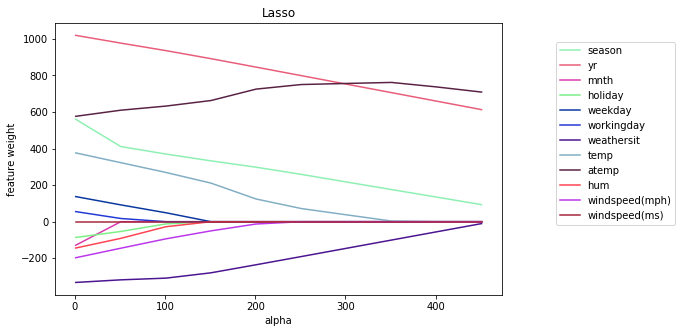

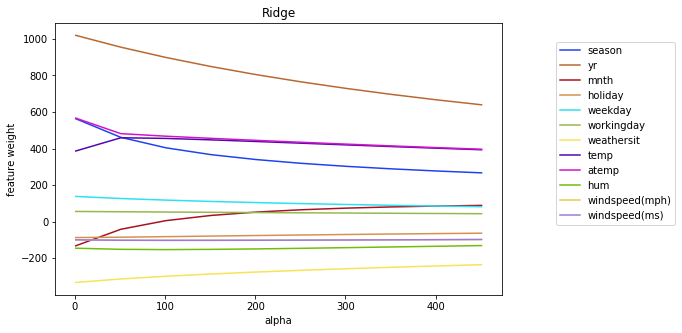

In [23]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")
#визуализируем динамику весов при увеличении параметра регуляризации

**Вывод: При alpha > 0 Lasso исключает один из признаков windspeed. Ridge не исключает признаки, а уменьшает оба коэффициента при windspees до примерно одинакового значения**

### Подбор наилучшего alpha (параметра регуляризации)

Выбранное alpha: 6


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


['season : 532.018982841354',
 'yr : 1015.0602226430597',
 'mnth : -100.03952614356668',
 'holiday : -83.2939598752991',
 'weekday : 132.50446549095787',
 'workingday : 51.55708561407389',
 'weathersit : -330.5598567399812',
 'temp : 370.6798550300362',
 'atemp : 581.3969310654958',
 'hum : -140.00740550068878',
 'windspeed(mph) : -191.77140847135155',
 'windspeed(ms) : -2.6853782866626636e-08']

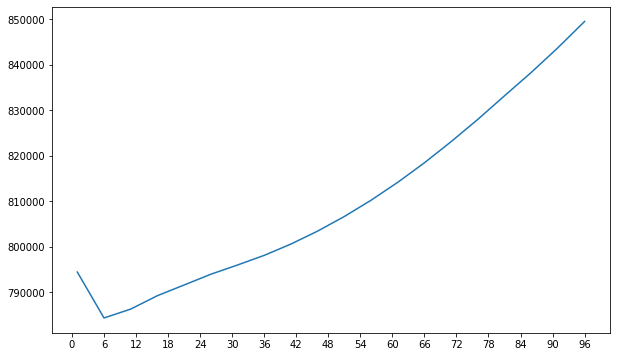

In [26]:
alphas = np.arange(1, 100, 5)
lassocv_reg = LassoCV(alphas=alphas) #регрессор LassoCV (кросс-валидацию для регрессии)
lassocv_reg.fit(X, y) #обучение
plt.figure(figsize=(10, 6))
p = plt.plot(lassocv_reg.alphas_, lassocv_reg.mse_path_.mean(axis=1))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6)) # визуализация усредненного по строкам MSE в зависимости от alpha
print('Выбранное alpha: {}'.format(lassocv_reg.alpha_)) #вывод выбранного alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
['{} : {}'.format(b, a) for a, b in zip(lassocv_reg.coef_, df.columns)]

При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.